## Evaluate models

### Owlvit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aircraft_anomaly_detection.models.owlvit import OwlViT
from aircraft_anomaly_detection.interfaces import Annotation

In [ ]:

pred_anns = []
grd_anns = []

for i in range(1, 12):
    # image, label, meta = turbine_ad[i]
    image_path = f"../data/LTAA-FLUX-Small-test-dataset-generated/Generated/Flux_{i}.jpg"
    # image_path = "../data/no_defect/detail_jet-engine-part.jpg"
    texts = ["a clean, undamaged metal surface", "a close-up image of a metal scratch"]

    owlvit = OwlViT()
    ann = owlvit.predict(image_input=image_path, text_prompts=texts, undamaged_idxes=[0], top_k=2)

    pred_anns.append(ann)
    # All damaged
    grd_anns.append(
        Annotation(
            damaged=True,
        )
    )

/home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '../data/LTAA-FLUX-Small-test-dataset-generated/Generated/Flux_1.jpg'

In [2]:
from aircraft_anomaly_detection.eval.evaluator import Evaluator

evaluator = Evaluator(pred_anns, grd_anns)
evaluator.eval()

{'accuracy': 1.0, 'f1_score': 1.0}

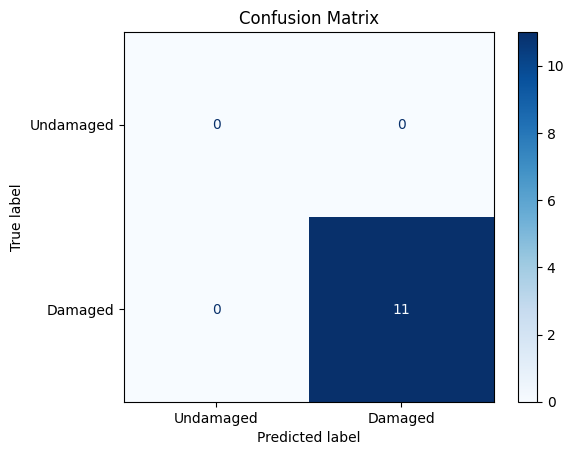

In [3]:
evaluator.plot_confusion_matrix()

### Clip

In [1]:
from aircraft_anomaly_detection.models.clip_predictor import CLIP

predictor = CLIP(class_names=["damaged", "undamaged"], damaged_idxes=[0])

# Predict all images in a folder

anns = predictor.predict("../data/LTAA-FLUX-Small-test-dataset-generated/Generated/")

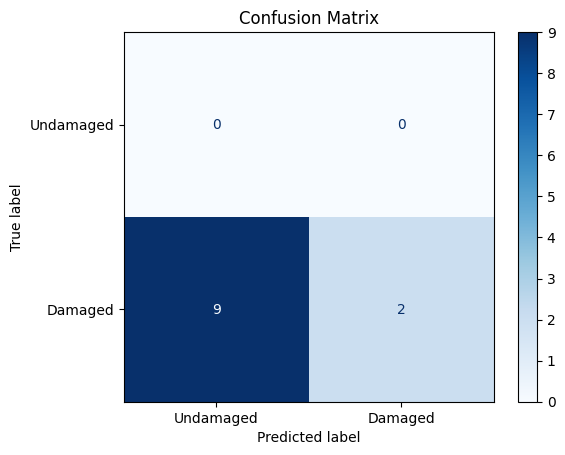

In [4]:
from aircraft_anomaly_detection.eval.evaluator import Evaluator

evaluator = Evaluator(anns, grd_anns)
evaluator.eval()
evaluator.plot_confusion_matrix()

Now lets investigate the MVTec dataset.

In [4]:
from aircraft_anomaly_detection.dataloader import AnomalyDataset

mvtec = AnomalyDataset("mvtech")

test = mvtec.filter_by(lambda fp, meta, label: meta.split == "test")


Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/capsule
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/transistor
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/carpet
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/grid
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/zipper
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/toothbrush
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/pill
Processing already extracted folder: /home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/m

In [4]:
print(test[0])

(<PIL.Image.Image image mode=RGB size=1000x1000 at 0x7240479C3B50>, 1, Metadata(component='capsule', condition='crack', ground_truth=PosixPath('/home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/capsule/ground_truth/crack/000_mask.png'), image_path=PosixPath('/home/lars/Documents/Uni/ETH/S2/DSL/aircraft-engine-anomaly-detection/data/mvtech/capsule/test/crack/000.png'), description='MVTech extracted_folder (test)', split='test'))


Now let us create the ground truth annotations for this.


In [11]:
from PIL import Image
import numpy as np


def png_to_mask(png_path: str) -> np.ndarray:
    """
    Convert a binary mask PNG image to a NumPy array.

    Args:
        png_path (str): Path to the PNG image.

    Returns:
        np.ndarray: Binary mask (1 where white, 0 where black).
    """
    image = Image.open(png_path).convert("L")  # Convert to grayscale
    mask = np.array(image)
    binary_mask = (mask > 127).astype(np.uint8)  # Threshold to binary
    return binary_mask

In [12]:
from tqdm.notebook import tqdm 

pred_anns = []
grd_anns = []

for i in tqdm(range(len(test.data)), desc="Processing", unit="image"):
    image, label, meta = test[i]

    texts = [meta.condition]

    owlvit = OwlViT()
    ann = owlvit.predict(
        image_input=image, text_prompts=texts, undamaged_idxes=[], top_k=2
    )
    if ann.bboxes == []:
        continue
    
    pred_anns.append(ann)

    gt_path = meta.ground_truth
    #will be a png but convert it to numpy array

    if label == 0:
        grd_anns.append(
            Annotation(
                damaged=False,
                mask=png_to_mask(gt_path),
            )
        )
    else:
        grd_anns.append(
            Annotation(
                damaged=True,
                mask=png_to_mask(gt_path),
            )
        )   
    break

Processing:   0%|          | 0/1725 [00:00<?, ?image/s]

In [15]:
pred_anns[0]

Annotation(image=<PIL.Image.Image image mode=RGB size=1000x1000 at 0x7B63459385B0>, damaged=True, bboxes=[[858, 522, 912, 600]], scores=[0.015888644382357597], bboxes_labels=['crack'], mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 1000), dtype=uint8))

In [16]:
grd_anns[0]

Annotation(image=None, damaged=True, bboxes=[], scores=[], bboxes_labels=[], mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 1000), dtype=uint8))

In [17]:
from aircraft_anomaly_detection.eval.evaluator import Evaluator

evaluator = Evaluator(pred_anns, grd_anns)
evaluator.eval()

{'accuracy': 1.0, 'f1_score': 1.0, 'IoU': np.float64(0.49908864954432475)}

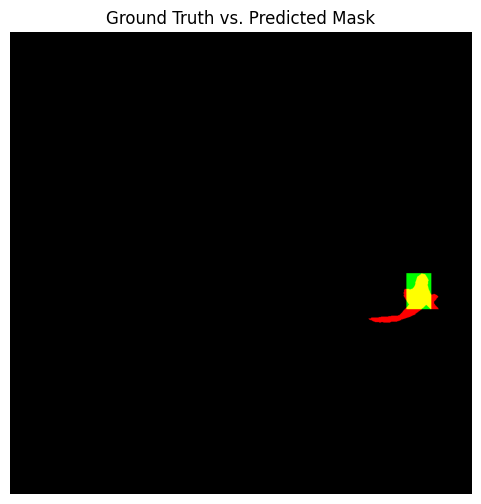

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_mask_overlap(
    mask1: np.ndarray, mask2: np.ndarray, title: str = "Mask Overlap"
):
    """
    Visualize two binary masks with overlap.

    Args:
        mask1 (np.ndarray): First binary mask (0 or 1).
        mask2 (np.ndarray): Second binary mask (0 or 1).
        title (str): Title of the plot.
    """
    # Create RGB image
    height, width = mask1.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Assign colors
    color_mask[mask1 == 1] = [255, 0, 0]  # Red
    color_mask[mask2 == 1] = [0, 255, 0]  # Green
    color_mask[(mask1 == 1) & (mask2 == 1)] = [255, 255, 0]  # Yellow for overlap

    plt.figure(figsize=(6, 6))
    plt.imshow(color_mask)
    plt.title(title)
    plt.axis("off")
    plt.show()

visualize_mask_overlap(
    grd_anns[0].mask, pred_anns[0].mask, title="Ground Truth vs. Predicted Mask"
)

In [7]:
#check if damaged is true for any
for i in range(len(pred_anns)):
    if pred_anns[i].damaged:
        print(f"Image {i} is damaged")

In [13]:
print(f"Predictions: {len(pred_anns)}")

Predictions: 1


It is worth noting that OWLViT sees to be really bad at anomaly detection on MVTeC even if it is looking for the 